In [1]:
import os
# switch to "osmesa" or "egl" before loading pyrender
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import pyrender
import trimesh
import matplotlib.pyplot as plt
from dcolmap.hgps.pose import Pose
from jax.scipy.spatial.transform import Rotation as R
import jax.numpy as jnp
from tqdm import tqdm
from dcolmap.hgps.camera import xyz_from_depth
from dcolmap.hgps.types import Intrinsics
from dcolmap.hgps.viz import PyRenderViz, depth_to_rgb
import jax

In [2]:
from diff_gaussian_rasterization import rasterize, rasterize_jit

In [3]:
import viser
server = viser.ViserServer()

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:8081   │
│   Websocket │ ws://0.0.0.0:8081     │
│             ╵                       │
╰─────────────────────────────────────╯

In [4]:
intrinsics = Intrinsics(200, 200, 300.0,300.0, 100.0, 100.0, 0.01, 10.0)
width, height, fx, fy, cx, cy, near, far = intrinsics
renderer = PyRenderViz(width, height, fx, fy, cx, cy, near, far )

In [5]:
meshpath = f"./assets/ycb_video_models/models/011_banana/textured_simple.obj"
trimesh_mesh = trimesh.load(meshpath)
# mesh = pyrender.Mesh.from_trimesh(trimesh.creation.box(jnp.ones(3)*0.05))

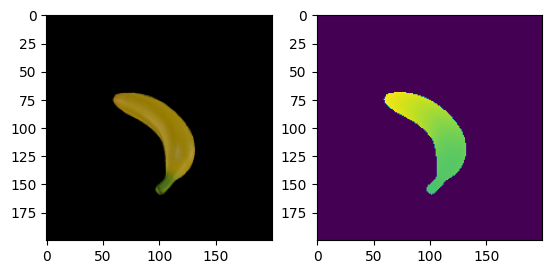

In [6]:
### Initialize GT image(s) to test on
angle = jnp.pi/2
num_images = 10
images = []
for angle in jnp.linspace(0.0, jnp.pi / 4, num_images):
    renderer.clear()
    renderer.add_trimesh(trimesh_mesh)
    camera_pose = Pose.from_quat(
        R.from_rotvec(jnp.array([1.3, 0.1, 0.1]) * angle).as_quat()
    ) @ Pose.from_position_and_target(jnp.array([0.25, 0.25, 0.25]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0]))
    images.append(renderer.capture_image(camera_pose))

gt_color, gt_depth = images[0]
fig,(ax1, ax2,) = plt.subplots(1,2)
im1 = ax1.imshow(gt_color)
im2 = ax2.imshow(gt_depth) #(depth_to_rgb(gt_depth))

### Optimization via Gaussian Splatting

In [7]:
key = jax.random.PRNGKey(3)

##### Optim helper functions

In [27]:
def _render_jax_with_param_transform(means3D, colors_precomp, opacity, scales, rotations,
           image_width, image_height, fx,fy, cx,cy,near,far, preproc=False):
    return rasterize(
        means3D, 
        colors_precomp, 
        jnp.exp(jax.nn.log_sigmoid(opacity)), 
        scales, 
        rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    ) 

render_jax_with_param_transform = jax.jit(_render_jax_with_param_transform, 
                                          static_argnums=(5,6,7,8,9,10,11,12,13))

def loss(means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far, color_gt, depth_gt):
    color = render_jax_with_param_transform(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )
    return jnp.sum(0.5 * (color[:3] - color_gt)**2) + jnp.sum(0.5 * (color[3] - depth_gt)**2) 

loss_grad = jax.jit(jax.value_and_grad(loss, argnums=(0,1,2,3,4,)), static_argnums=(5,6,7,8,9,10,11,12))

#### Setup initial data

(3, 200, 200) (200, 200)
(2514, 6)


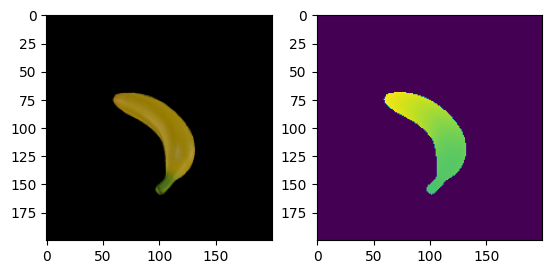

In [29]:
## Ground Truth
gt_color_transposed = jnp.transpose(gt_color, (2,0,1))
print(gt_color_transposed.shape, gt_depth.shape)


gt_xyz = xyz_from_depth(gt_depth, intrinsics).reshape(-1,3)
gt_rgb = gt_color.reshape(-1,3)
gt_rgbxyz = jnp.concatenate([gt_rgb, gt_xyz], axis=-1)
gt_rgbxyz = gt_rgbxyz[gt_rgbxyz[:, -1] > 0.0]
print(gt_rgbxyz.shape)
fig,(ax1, ax2,) = plt.subplots(1,2)
im1 = ax1.imshow(gt_color)
im2 = ax2.imshow(gt_depth) #(depth_to_rgb(gt_depth))

In [30]:
## Initialize data to optimize
N = 75
key = jax.random.PRNGKey(1222) # reproducibility
rgbxyz = gt_rgbxyz[jax.random.choice(key, gt_rgbxyz.shape[0], shape=(N,), replace=False)]  # sample point cloud from GT

# sample gaussian means from point cloud, with noise
key = jax.random.split(key, 1)[0]
mean_noise = jax.random.uniform(key, shape=(N,3), minval=-0.05, maxval=0.05)
means3D = rgbxyz[:,3:] + mean_noise

# random colors (0-1 floats)
key = jax.random.split(key, 1)[0]
color_noise = jax.random.uniform(key, shape=(N,3), minval=-0.3, maxval=0.3)
_colors_precomp_unclipped = rgbxyz[:,:3] + color_noise
colors_precomp = jnp.clip(_colors_precomp_unclipped, a_min=0.0, a_max=1.0, out=None) 

# opacity, scales to 1  
opacity = jnp.ones(shape=(N,1)) * 1e6  # sigmoid to 1
scales = jnp.ones((N,3)) * 0.005

# random rotations
key = jax.random.split(key, 1)[0]
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

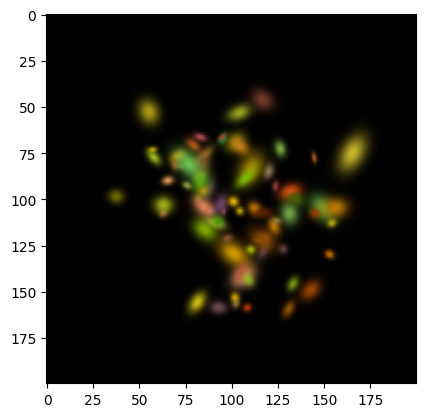

In [31]:
# visualize initial condition
init_params = (means3D, colors_precomp, opacity, scales, rotations)

color_init = render_jax_with_param_transform(
        *init_params,
        intrinsics.width, intrinsics.height, intrinsics.fx, intrinsics.fy, 
        intrinsics.cx, intrinsics.cy,
        intrinsics.near, intrinsics.far
    )

init_color = color_init[:3, :, :]
fig, ax1 = plt.subplots(1,1)
im1 = ax1.imshow(jnp.transpose(init_color, (1,2,0)))


In [32]:
import optax
it = 300

params = init_params
param_labels = ("means3D", "colors_precomp", "opacity", "scales", "rotations")
tx = optax.multi_transform(
    {
        'means3D': optax.adam(0.001),
        'colors_precomp': optax.adam(0.001),
        'opacity': optax.adam(0.0001), # or 0.001
        'scales': optax.adam(0.0001),
        'rotations': optax.adam(0.0001),
    },
    param_labels
)
state = tx.init(params)


In [33]:
pbar = tqdm(range(it))

interms = []


for _ in pbar:
    loss_val_jax, gradients_jax = loss_grad(
        *params,
        intrinsics.width, intrinsics.height, intrinsics.fx, intrinsics.fy, 
        intrinsics.cx, intrinsics.cy,
        intrinsics.near, intrinsics.far, gt_color_transposed, gt_depth
    )
    (dL_dmeans3D, dL_dcolors, dL_dopacity, dL_dscales, dL_drotations) = gradients_jax
    pbar.set_description(f"loss: {loss_val_jax.item()}")

    gradients_jax = (dL_dmeans3D, dL_dcolors[:, :3], dL_dopacity, dL_dscales, dL_drotations)

    updates, state = tx.update(gradients_jax, state, params)
    params = optax.apply_updates(params, updates)

    ## Viz
    color_and_depth_intermediate = render_jax_with_param_transform(
            *params,
            intrinsics.width, intrinsics.height, intrinsics.fx, intrinsics.fy, 
            intrinsics.cx, intrinsics.cy,
            intrinsics.near, intrinsics.far
        )
    interms.append(color_and_depth_intermediate)

  0%|          | 0/300 [00:00<?, ?it/s]

loss: 166.28994750976562: 100%|██████████| 300/300 [00:05<00:00, 52.83it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


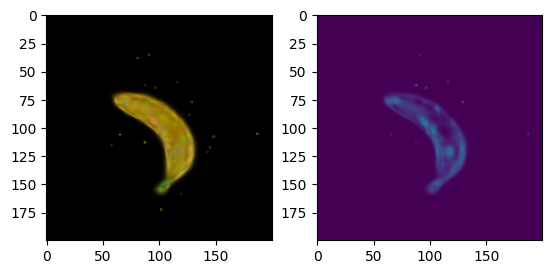

In [34]:
# plot final jax
color_and_depth_optim = render_jax_with_param_transform(
        *params,
        intrinsics.width, intrinsics.height, intrinsics.fx, intrinsics.fy, 
        intrinsics.cx, intrinsics.cy,
        intrinsics.near, intrinsics.far
    )

optim_color, optim_depth = color_and_depth_optim[:3, :, :], color_and_depth_optim[3, :, :]
fig,(ax1, ax2,) = plt.subplots(1,2)
im1 = ax1.imshow(jnp.transpose(optim_color, (1,2,0)))
im2 = ax2.imshow(optim_depth, vmin=0, vmax=gt_depth.max()) #(depth_to_rgb(gt_depth))

0 0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 80 130 180 230 280 299 299 299 299 299 299 299 299 299 299 0 

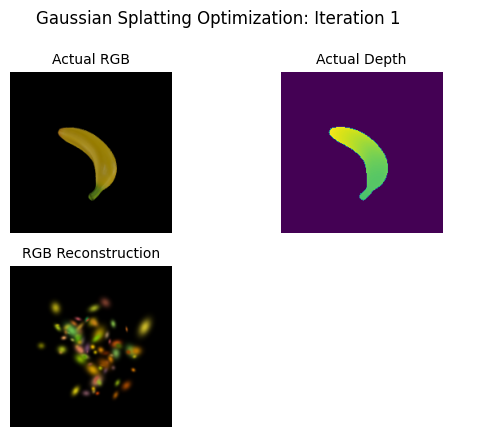

In [35]:
import matplotlib.animation as animation

fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
for ax in (ax1, ax2, ax3, ax4): ax.axis("off")
title_fontsz = 10  

ax1.set_title("Actual RGB", fontsize=title_fontsz)
im1 = ax1.imshow((gt_color*255).astype('uint8'))

ax2.set_title("Actual Depth", fontsize=title_fontsz)
im2 = ax2.imshow(gt_depth, vmin=0, vmax=gt_depth.max())

ax3.set_title("RGB Reconstruction", fontsize=title_fontsz)
im3 = ax3.imshow(jnp.transpose(init_color, (1,2,0)).astype('uint8'))


fig.subplots_adjust(top=0.85)

frame_interval = 50 
fps = 10
def animate_optim(fi):
    interm_color, interm_depth = interms[fi][:3, :, :], interms[fi][3, :, :]

    im3.set_array(jnp.transpose(interm_color * 255, (1,2,0)).astype('uint8'))  # avoid plt warning
    # im4.set_array(interm_depth)

    fig.suptitle(f"Gaussian Splatting Optimization: Iteration {fi + 1}", fontsize=12)

    print(fi, end=" ")

ani = animation.FuncAnimation(fig, animate_optim, repeat=True,
                                    frames=[x for x in range(0, 30, 2)] + [x for x in range(30, it, frame_interval)] + [it-1 for _ in range(fps * 1)], 
                                    interval=50)

from matplotlib.animation import FuncAnimation, PillowWriter
ani.save("optim.gif", dpi=300, writer=PillowWriter(fps=fps))
